<a href="https://colab.research.google.com/github/skc46/Magnetic_material_science_research_related/blob/master/Precise_lattice_parameter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finding true lattice parameter using Cohen method

### In case of Cubic crystal

In the experimental X-ray diffraction (XRD) pattern, one obtains a set of peaks corresponding to different cyrstal orientation. Then from the angular position of these peaks, one can estimate the unit cell lattice parameter (a) using equation: $$ \frac{sin^2\theta}{(h^2+k^2+l^2)} = \frac{sin^2\theta}{s} = \frac{\lambda^2}{4a^2} = A (say) \tag{1}$$  

However, since the diffractometer uncertainity depends upon its angular position (diffractometer is generally more accurate at higher angle), the calculated lattice parameter for different peaks yields slightly different value. Then the problem at hand is how to determine the true lattice parameter from the set of values (i.e. $a_i$). To some degree, the averaging may give a decent estimate, but that neglects the fact that the systematic uncertainity of the diffractometer is not constant. The better solution to this issue is to weight $a_i$ more when the diffractor is more accurate.

Cohen [[1]](https://doi.org/10.1063/1.1751937) tried to solve this issue by presuming angular-dependent systematic error in $ sin^2\theta $ values of $ DF(\theta) $, where $ D $ is a (specimen-dependent) constant and $ F(\theta) $ is the function describing the systematic error. Cohen's idea was later revised by Nelson-Riley [[2]](https://doi.org/10.1088/0959-5309/57/3/302) with the better error function to determine the precise lattice parameter. The generalized equation can be written as: $$ \sin^2\theta = \frac{\lambda^2}{4a_0^2}(h^2 + k^2 + l^2) + 2D\sin^2\theta[\frac{\cos^2\theta}{\sin\theta} + \frac{\cos^2\theta}{\theta}] \tag{2}$$
         
In the RHS of above equation, the terms inside the square bracket defines the error function. $ a_0 $ represents the precise lattice parameter. For each peak, the angle ($ \theta $) and $ s = (h^2+k^2+l^2) $ will be different, hence we can write the above equation as; $$ \sin^2\theta_i = As_i + D\delta_i \tag{3}$$        
                      
                      
For convenience, we define; $$ 10{\sin^22\theta_i}(\frac{1}{\sin\theta_i} + \frac{1}{\theta_i}) = \delta_i \tag{4}$$
The factor 10 is introduced to make of various terms to have same magnitude.

In equation (3), the LHS represents experimentally determined values of $ sin^2\theta $. The first term in RHS (i.e, $ As $) represents the predicted value based on true lattice parameter and the sum of squares of miller indeces, whereas the last term (i.e., $ D\delta $) is the error related term. One can generalize equation (3) as the experimentally observed value is equal to the predicted value plus the systematic error term. Then the problem at hand is to find the cofficients of A and D such that it minimizes the sum of squares of difference between observed and predicted values, that is; $$ minimize \sum \limits_{i}(\sin^2\theta_i - As_i - D\delta_i)^2 = error $$

This can be solved by least square method, which we show below.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### Insert your experimental 2$\theta$ value and corresponding $ s = (h^2 + k^2 + l^2)$.

In [23]:
peak_2T = [30.5923,35.4631, 51.0163, 60.7298,63.7423,75.0204, 85.8522,96.4943,104.704,119.1519]   # experimentally observed 2theta values
s = [3,4, 8,11,12, 16, 20, 24, 27,32]  # s = (h2 + k2 + l2), it should be corresponding to the peaks above
X_ray_source = 'Co'  # change it  to 'Cu' if Cu source was used

if X_ray_source =='Co':
    Lambda = 1.7890100
elif X_ray_source =='Cu':
    Lambda = 1.5401

if len(peak_2T) == len(s):
    twoT_array = np.array(peak_2T)
    s_array    = np.array(s)
else:
    print("Error: The number of peak positions do not match with s values, check your values! ")
    
print("The values you entered...")
df = pd.DataFrame({'twoTheta':twoT_array, 's':s_array}, columns=['twoTheta', 's'])
df


The values you entered...


,twoTheta,s
0,30.5923,3
1,35.4631,4
2,51.0163,8
3,60.7298,11
4,63.7423,12
5,75.0204,16
6,85.8522,20
7,96.4943,24
8,104.7040,27
9,119.1519,32


In [24]:
Theta2rad=np.radians(df.twoTheta)
Thetarad = np.radians(df.twoTheta/2)
z = np.power(np.sin(Thetarad),2)    # here z =  sin^2(theta)
y =(1/np.sin(Thetarad))+(1/Thetarad)
delta = 10*np.power(np.sin(Theta2rad),2)*y  # delta based on Riley
s_i =df.s   # alpha equals squares of h,k and l

# we can find A and D by solving the normal equations
def findAC(s_i,delta,z):
    A = ((s_i*delta).sum()*(delta*z).sum()-np.power(delta,2).sum()*(s_i*z).sum())/(np.power((s_i*delta).sum(),2)-np.power(s_i,2).sum()*np.power(delta,2).sum())
    D = ((s_i*delta).sum()*(s_i*z).sum()-(s_i*s_i).sum()*(delta*z).sum())/(np.power((s_i*delta).sum(),2)-(np.power(s_i,2).sum()*np.power(delta,2).sum()))
    return A,D
def LatticePara():
    A,D = findAC(s_i,delta,z)
    a_true = Lambda/(2*np.sqrt(A))
    return a_true
# One can also find A and D directly using linalg.lstsq method, this also allows one to estimate the error

df['delta'] = 10*np.power(np.sin(Theta2rad),2)*(1/np.sin(Thetarad)+1/Thetarad)  # delta based on Riley
x = df.iloc[:,1:3]
para, residuals,rank,s = np.linalg.lstsq(x,z, rcond=1e-6)
a_true_ls = Lambda/(2*np.sqrt(para[0]))
MSE_A = np.mean(residuals[0])
a_true_error = 0.5 * (MSE_A/para[0])*a_true_ls
print("True lattice parameter solving normal equation: {:.4f}".format(LatticePara()), u'\u212B')
print("True lattice parameter using direct leastsquare method: {:.4f}".format(a_true_ls), u"\u00B1", '{:.4f}'.format(a_true_error), u'\u212B')

True lattice parameter solving normal equation: 5.8694 Å
True lattice parameter using direct leastsquare method: 5.8694 ± 0.0002 Å


#### data visualization

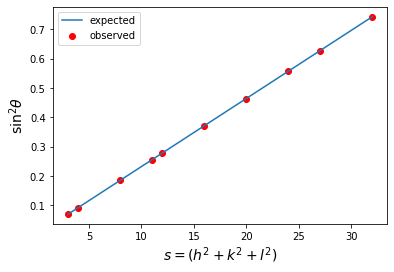

In [25]:
plt.scatter(df.s, z ,color='red', label='observed')
plt.plot(df.s,(df.s*para[0]), label='expected')
plt.ylabel(r'sin$^2{\theta}$', fontsize=14)
plt.xlabel(r'$s=(h^2 + k^2 + l^2)$', fontsize =14)
plt.legend()

Instead of Nelson-Riely, one could also use Bradley-Jay error function. In this case, it sufficient to replace the error function, which is as follows; $$ \sin^2\theta = \frac{\lambda^2}{4a_0^2}(h^2 + k^2 + l^2) + D\sin^22\theta \tag{5}$$

Hence, $$  \delta_i = 10{\sin^22\theta_i} \tag{6}$$


In [ ]:
df['delta_BJ'] = 10*np.power(np.sin(Theta2rad),2)   # delta based on Bradley- Jay
x_BJ = df[['s','delta_BJ']]
para_BJ, residuals_BJ,rank,s = np.linalg.lstsq(x_BJ,z, rcond=1e-6)
a_true_BJ = Lambda/(2*np.sqrt(para_BJ[0]))
MSE_A_BJ = np.mean(residuals_BJ[0])
a_true_BJ_error = 0.5 * (MSE_A_BJ/para_BJ[0])*a_true_BJ
per_diff = 100*np.abs((a_true_ls - a_true_BJ))/a_true
print("True lattice parameter based on Bradley-Jay: {:.4f}".format(a_true_BJ), u"\u00B1", '{:.4f}'.format(a_true_BJ_error), u'\u212B')
print("The percentage difference between Nelson_Riely and Bradler_Jay is {:.4f}%".format(per_diff))

True lattice parameter based on Bradley-Jay: 5.7420 ± 0.0001 Å
The percentage difference between Nelson_Riely and Bradler_Jay is 0.0004%


### One can extend this idea for hexagonal crystal

For hexagonal system equation (2) could be modified as; $$ \sin^2\theta = \frac{\lambda^2}{3a_0^2}(h^2 + hk + k^2) + \frac{\lambda^2}{4c_0^2}l^2 + 2D\sin^2\theta[\frac{\cos^2\theta}{\sin\theta} + \frac{\cos^2\theta}{\theta}] \tag{7}$$

Here we are interested in two true parameters; $a_0$ and $c_0$  

Similary, equation (3) can be written as; $$ \sin^2\theta_i = A\alpha_i +  B\beta_i + D\delta_i \tag{8}$$ 

Here $\alpha_i = (h^2 + hk + k^2)$ and $\beta_i = l^2$. One can then find true values of a and c by estimating A and C so that the error: $$ \sum \limits_{i}(\sin^2\theta_i - A\alpha_i - B\beta_i - D\delta_i)^2 \tag{9}$$ is minimized.

Since there are three parameters, solving it by normal equations involves many parameters. Hence, we will estimate A, B, and D by using `np.linalg.lstsq` method.

In [ ]:
peak_2T = [22.464, 39.728, 46.214, 49.09, 62.57, 82.389, 85.655, 92.328, 103.44, 108.71]   # experimentally observed 2theta values
alpha = [1, 3, 4,0,7, 1, 12, 9,16,16]  # alpha = (h2 + hk + k2), it should be corresponding to the peaks above
beta  = [0, 0, 0, 4,0,9,0,4,0,1]
X_ray_source = 'Co'  # change it  to 'Cu' if Cu source was used

if X_ray_source =='Co':
    Lambda = 1.7890100
elif X_ray_source =='Cu':
    Lambda = 1.5401

if len(peak_2T) == len(alpha) == len(beta):
    twoT_array = np.array(peak_2T)
    alpha_array  = np.array(alpha)
    beta_array   = np.array(beta)
else:
    print("Error: The number of peak positions do not match with s values, check your values! ")
    
print("The values you entered...")
df_hex = pd.DataFrame({'twoTheta':twoT_array, 'alpha':alpha_array, 'beta':beta_array}, columns=['twoTheta', 'alpha', 'beta'])
df_hex

The values you entered...


,twoTheta,alpha,beta
0,22.464,1,0
1,39.728,3,0
2,46.214,4,0
3,49.090,0,4
4,62.570,7,0
5,82.389,1,9
6,85.655,12,0
7,92.328,9,4
8,103.440,16,0
9,108.710,16,1


In [ ]:
Theta2rad = np.radians(df_hex.twoTheta)
Thetarad = np.radians(df_hex.twoTheta/2)
z = np.power(np.sin(Thetarad),2)    #here z =  sin^2(theta)

df_hex['delta'] = 10*np.power(np.sin(Theta2rad),2)*(1/np.sin(Thetarad)+1/Thetarad)  # delta based on Riley
x = df_hex.iloc[:,1:4]
para, residuals,rank,s = np.linalg.lstsq(x,z,rcond=1e-6)
a_true = Lambda/(np.sqrt(3*para[0]))
c_true = Lambda/(2*np.sqrt(para[1]))
print("a0: {:.4f}".format(a_true), u'\u212B')
print("c0: {:.4f}".format(c_true), u'\u212B')

a0: 5.2598 Å
c0: 4.2719 Å


Instead of Nelson-Riely, one could also use Bradley-Jay error function. In this case, it sufficient to replace the error function, which is as follows; $$ \sin^2\theta = \frac{\lambda^2}{3a_0^2}(h^2 + hk + k^2) + \frac{\lambda^2}{4c_0^2}l^2 + D\sin^22\theta \tag{10}$$



In [ ]:
df_hex['delta_BJ'] = 10*np.power(np.sin(Theta2rad),2)   # delta based on Bradley- Jay
x1 = df_hex[['alpha','beta','delta_BJ']]
para, residuals,rank,s = np.linalg.lstsq(x1,z, rcond=1e-6)
a_true_BJ = Lambda/(np.sqrt(3*para[0]))
c_true_BJ = Lambda/(2*np.sqrt(para[1]))
print("a0_BJ: {:.4f}".format(a_true_BJ), u'\u212B')
print("c0_BJ: {:.4f}".format(c_true_BJ), u'\u212B')

a0_BJ: 5.2567 Å
c0_BJ: 4.2691 Å
